In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
from scipy import stats as scipy_stats
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import Polygon

Much of this notebook comes from: https://www.youtube.com/watch?v=VIr-pejky6E

## Bring in raster data

In [2]:
# Slope calculated with GDAL
# from osgeo import gdal
# gdal.DEMProcessing('downtown_slope.tif', 'downtown_dsm.tif', 'slope')

dsm_path = "../missoula_data/downtown_slope.tif"
dsm = rasterio.open(dsm_path)
dsm.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 1571,
 'height': 1645,
 'count': 1,
 'crs': CRS.from_epsg(6514),
 'transform': Affine(0.9144000000087544, 0.0, 257075.3304003399,
        0.0, -0.9144000000087544, 301627.6416007468)}

## Bring in vector data

In [3]:
bldgs_path = "../missoula_data/downtown_bldgs.shp"
bldgs = gpd.read_file(bldgs_path).to_crs(6514)

In [4]:
bldgs

,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,geometry
0,1.0,27.32460,3202.73,44334.900,MULTIPOLYGON Z (((257091.482 300124.221 27.325...
1,2.0,11.80030,3204.72,5449.480,"POLYGON Z ((257170.740 300266.436 11.800, 2571..."
2,3.0,11.44360,3205.74,3658.490,"POLYGON Z ((257170.172 300185.933 11.444, 2571..."
3,4.0,30.45860,3205.99,13970.200,MULTIPOLYGON Z (((257408.449 300123.800 30.459...
4,5.0,10.99220,3204.42,6748.850,"POLYGON Z ((257175.485 300291.266 10.992, 2571..."
...,...,...,...,...,...
958,959.0,10.41030,3217.27,566.998,"POLYGON Z ((258263.976 301156.751 10.410, 2582..."
959,960.0,17.13810,3214.29,2976.740,"POLYGON Z ((258224.819 301179.597 17.138, 2582..."
960,961.0,16.08160,3217.24,1456.870,"POLYGON Z ((258300.759 301228.699 16.082, 2582..."
961,962.0,9.34612,3216.50,272.249,"POLYGON Z ((258217.425 301179.456 9.346, 25822..."


## Plot buildings and surface DEM

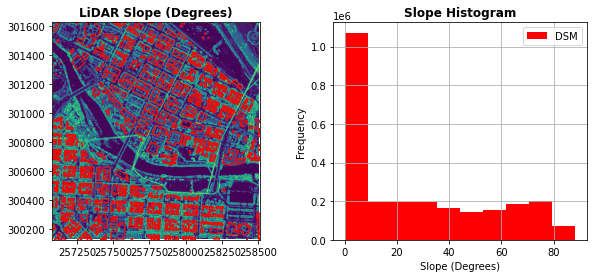

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
show(dsm, ax = ax1, title= 'LiDAR Slope (Degrees)')
bldgs.plot(ax = ax1, facecolor='None', edgecolor='red')
show_hist(dsm, title='Slope Histogram', ax=ax2, label='DSM')
ax2.set_xlabel('Slope (Degrees)')
plt.show()

## Determine Roof Pitch

In [36]:
# Assign raster values to a numpy array
dsm_arr = dsm.read(1)

affine = dsm.transform

### Assumption that a slope of 5 degrees is small enough to allow a garden. 
### This number will likely need to be changed in the future.
threshold = 15

# If a pixel's slope is greater than 5 degrees, assign a 0, otherwise assign a 1. 
# Then sum the pixels and calculate area.
def flat_area(x):

    slope = np.where(x > threshold, 0, 1)
    flat_count = np.sum(slope)
    
    return flat_count * affine[0] * -affine[4]

# Calculate zonal statistics
zstats = rasterstats.zonal_stats(bldgs, dsm_arr, affine=affine,
    nodata=dsm.nodata, geojson_out=True, add_stats={'flat_area': flat_area})

## Add flat area to geopandas dataframe

In [49]:
# Extract flat area from stats
fa = []
for bldg_stats in zstats:
    bldg_fa = (bldg_stats['properties']['fid'], bldg_stats['properties']['flat_area']*3.28084)
    fa.append(bldg_fa)

fa_df = gpd.GeoDataFrame(fa, columns=['fid', 'fa_sq_ft'])
full_data = pd.merge(bldgs, fa_df)

In [50]:
# Reorder columns 
cols = full_data.columns.tolist()
cols.insert(4, cols[-1])
full_data = full_data[cols[:-1]]

In [51]:
# Fix datatype issue
full_data = full_data.astype({'fa_sq_ft': np.float64}, copy=True)
full_data['fa_perc'] = (full_data['fa_sq_ft'] / full_data['area_sq_ft']) * 100
full_data

,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,fa_sq_ft,geometry,fa_perc
0,1.0,27.32460,3202.73,44334.900,7242.048232,MULTIPOLYGON Z (((257091.482 300124.221 27.325...,16.334870
1,2.0,11.80030,3204.72,5449.480,1308.506442,"POLYGON Z ((257170.740 300266.436 11.800, 2571...",24.011584
2,3.0,11.44360,3205.74,3658.490,803.757626,"POLYGON Z ((257170.172 300185.933 11.444, 2571...",21.969655
3,4.0,30.45860,3205.99,13970.200,1431.950446,MULTIPOLYGON Z (((257408.449 300123.800 30.459...,10.250035
4,5.0,10.99220,3204.42,6748.850,951.890430,"POLYGON Z ((257175.485 300291.266 10.992, 2571...",14.104483
...,...,...,...,...,...,...,...
958,959.0,10.41030,3217.27,566.998,46.634401,"POLYGON Z ((258263.976 301156.751 10.410, 2582...",8.224791
959,960.0,17.13810,3214.29,2976.740,200.253606,"POLYGON Z ((258224.819 301179.597 17.138, 2582...",6.727279
960,961.0,16.08160,3217.24,1456.870,74.066402,"POLYGON Z ((258300.759 301228.699 16.082, 2582...",5.083940
961,962.0,9.34612,3216.50,272.249,5.486400,"POLYGON Z ((258217.425 301179.456 9.346, 25822...",2.015214


## Add whether or not rooftop is flat to dataframe

In [57]:
# Filter rooftops by percentage of flat area.
# This number is also a paramater that will likely need to be adjusted.
area_threshold = 15

# In this case, it looks like specifying a slope threshold of 15 degrees and an area threshold of 15% does
# a good job filtering out resedential buildings and picking up larger commercial buildings. 
full_data['flat'] = (full_data.fa_perc > area_threshold)

## Plot flat buildings

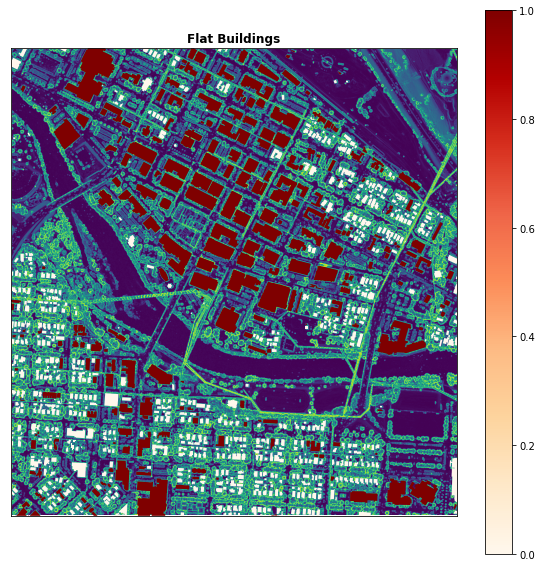

In [59]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
show(dsm, ax = ax, title= 'Flat Buildings')
full_data.plot(column='flat', legend=True, ax=ax, cmap='OrRd')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.show()

## Write to shapefile

In [61]:
full_data.to_file("../missoula_data/downtown_bldgs_flat.shp")